In [1]:
import networkx as nx
import pickle
import tqdm
import pandas as pd
import logging
import plotly.express as px
import plotly.io as pio
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import os
from copy import copy
from networkx.algorithms import bipartite
from itertools import product, chain
from collections import Counter
# from utils import cleanCompany

import gravis as gv 

# Plotting preferences
pio.templates.default = "plotly_white"




In [2]:
# Load dataset
from os import listdir
data_path = "C:\\Users\\jinfe\\Documents\\GitHub_dataset\\link_prediction_in_supply_chain\\USAID_GHSC-PSM_Health_Commodity_Delivery_Dataset_20240708.csv"
interested_cols = [
    'Country',
    'Item_Tracer_Category',
    'Product_Category',
    'Product_Name',
    'UOM',
    'D365_Health_Element',
    'Illustrative_Price',
    'Ordered_Quantity'
    ]
# listdir(data_path)

us_health_commodity_df = pd.read_csv(data_path)
us_health_commodity_df.columns = us_health_commodity_df.columns.str.replace(' ', '_')
dataset = us_health_commodity_df[interested_cols]
dataset.head(3)

c:\Users\jinfe\Documents\GitHub\supply_chain\.conda\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (74,75,76,87,88,89,91,92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Country,Item_Tracer_Category,Product_Category,Product_Name,UOM,D365_Health_Element,Illustrative_Price,Ordered_Quantity
0,Zambia,Laboratory,Laboratory Reagents,"COBAS c111 Cuvette Segments, 10 x 168, 1 Pack",UNT,HIV/AIDS,341.86,186
1,Mozambique,Laboratory,Laboratory Consumables,"Centrifuge Tube 50 mL, Polypropylene, Conical ...",UNT,HIV/AIDS,25.75,15
2,Zambia,Laboratory,Laboratory Reagents,"ABX Minotrol 16 Twin-Pack, High, 2 x 2.5 mL, 1...",PKG,HIV/AIDS,137.00,210


In [74]:
dataset.D365_Health_Element.value_counts()

HIV/AIDS                                         27646
Malaria                                           5551
Pandemic Influenza and Other Emerging Threats     1744
Family Planning and Reproduction                  1633
Maternal and Child Health                         1229
RDC                                               1035
Other Public Health Threats                        312
HIV                                                  2
311Mission                                           1
Tuberculosis                                         1
Population TO3                                       1
Name: D365_Health_Element, dtype: int64

In [76]:
dataset.Item_Tracer_Category.value_counts()

Laboratory                                            18239
Adult ARV                                              3312
Other Non-Pharma                                       2884
Other Pharma                                           2632
ACTs                                                   2223
COVID19                                                1762
Pediatric ARV                                          1696
Condoms                                                1332
LLINs                                                   903
VMMC                                                    796
Injectable Contraceptives                               541
mRDTs                                                   521
Severe Malaria Meds                                     516
Implantable Contraceptives                              430
TB HIV                                                  420
Combined Oral Contraceptives                            329
SMC                                     

In [77]:
dataset.Product_Category.value_counts()

Laboratory Reagents                              9164
Laboratory Consumables                           7730
HIV/AIDS Pharmaceuticals                         5008
Malaria Pharmaceuticals                          3220
Essential Medicines                              3026
Others                                           1577
Medical Supplies                                 1455
Laboratory Equipment                             1253
Respiratory Support                              1129
Male Condoms                                      909
Long Lasting Insecticide Treated Nets (LLINs)     903
Voluntary Male Circumcision (VMMC) Kits           672
Oral Contraceptives                               574
Injectable Contraceptives                         544
Malaria Rapid Diagnostic Test (RDTs)              526
Contraceptive Implants                            439
Female Condoms                                    268
General Patient Care                              267
Personal Protective Equipmen

### create digraph with edge added

In [103]:
item_product_category = dataset[['Item_Tracer_Category','Product_Category']]

bG = nx.DiGraph()
item_product_category = item_product_category.apply(lambda x: x.str.title())
bG.add_edges_from([(u, v) for u, v in item_product_category.values])

# Now clean the original bG and create bG_clean
item_cat_bg = set(item_product_category['Item_Tracer_Category'].values)
prod_cat_bg = set(item_product_category['Product_Category'].values)
products_in_source = list(item_cat_bg.intersection(prod_cat_bg))

bG

edge_df_bG = nx.to_pandas_edgelist(bG)

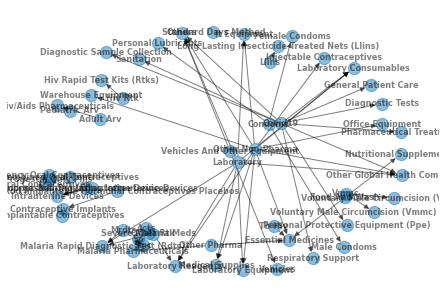

In [84]:
bG.edges
nx.draw(bG, with_labels=True, node_size=150, font_size=8, alpha=0.5, font_weight="bold", arrows=True)

In [85]:

gv.d3(
    bG, 
     
    # graph specs
    graph_height=500,
    
    # node specs
    node_size_data_source="betweenness_centrality",
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,
    show_node_label=True,
    node_label_data_source='node_identifier',
    
    # edge specs
    edge_size_data_source='feature1',
    use_edge_size_normalization=True,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,

    # force-directed graph specs
    many_body_force_strength=-500
)

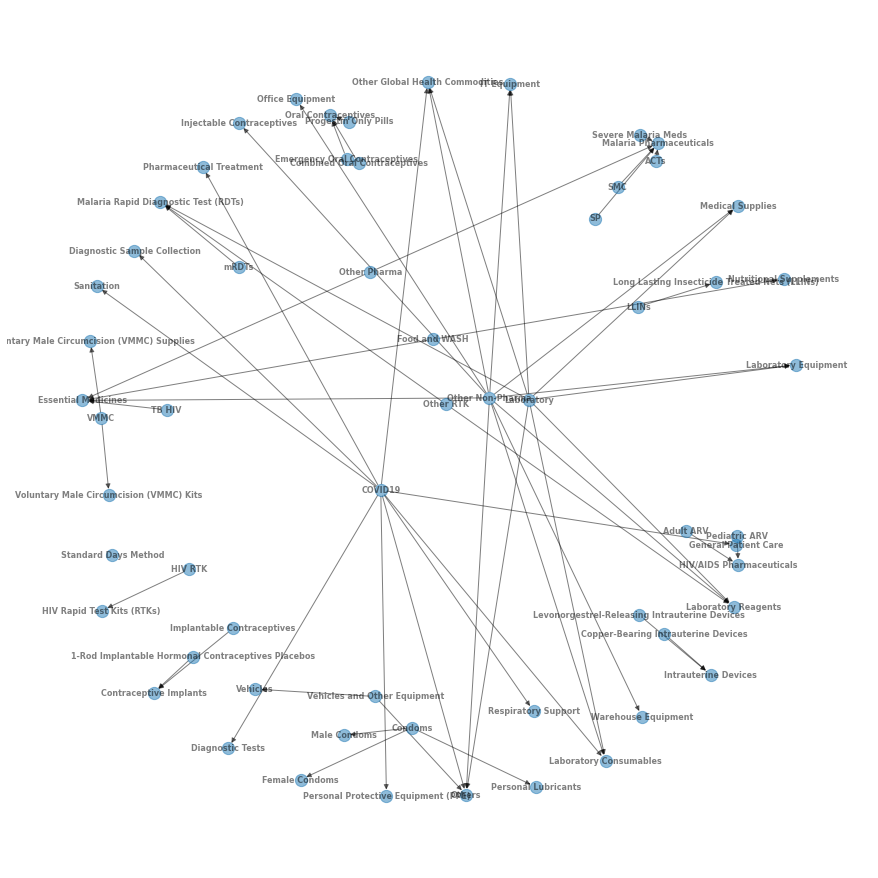

In [31]:
plt.figure(3,figsize=(12,12)) 
G=nx.from_pandas_edgelist(dataset, 'Item_Tracer_Category', 'Product_Category', create_using=nx.DiGraph()) 
nx.draw(G, with_labels=True, node_size=150, font_size=8, alpha=0.5, font_weight="bold", arrows=True)

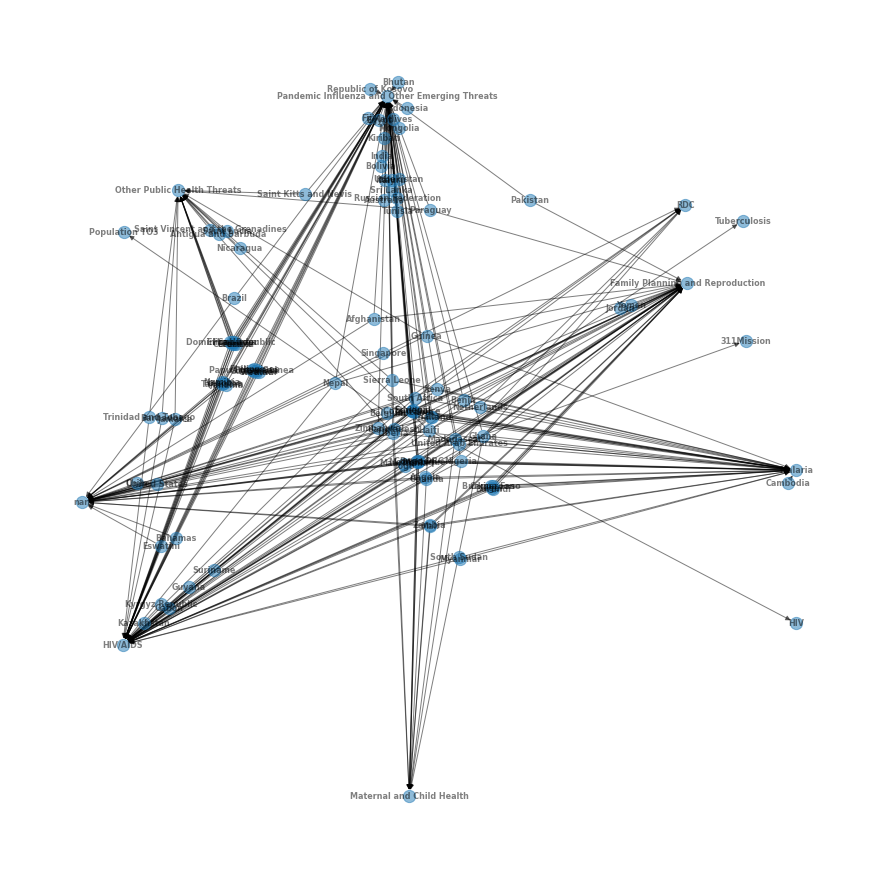

In [88]:
plt.figure(3,figsize=(12,12)) 
G=nx.from_pandas_edgelist(dataset[['Country', 'D365_Health_Element']].drop_duplicates(), 'Country', 'D365_Health_Element', create_using=nx.DiGraph()) 
nx.draw(G, with_labels=True, node_size=150, font_size=8, alpha=0.5, font_weight="bold", arrows=True)

In [3]:
G=nx.from_pandas_edgelist(dataset[['Country', 'D365_Health_Element']].drop_duplicates().dropna(), 'Country', 'D365_Health_Element', create_using=nx.Graph()) 
# Centrality calculation
centrality = nx.algorithms.degree_centrality(G)
# Community detection
communities = nx.algorithms.community.greedy_modularity_communities(G)


# Assignment of node sizes
nx.set_node_attributes(G, centrality, 'size')

# Assignment of node colors
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

gv.d3(G, use_node_size_normalization=True, node_size_normalization_max=10,
      use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3)

In [49]:
import random

random.seed(50)

graph_df = dataset[['Country', 'D365_Health_Element','Illustrative_Price','Ordered_Quantity']].drop_duplicates().dropna()
graph_df['total_spending'] = graph_df['Illustrative_Price'] * graph_df['Ordered_Quantity']
graph_df['weight'] = graph_df.groupby(['Country', 'D365_Health_Element'])['total_spending'].transform('sum')
graph_df = graph_df[['Country', 'D365_Health_Element','weight']].drop_duplicates()

G=nx.from_pandas_edgelist(graph_df, 'Country', 'D365_Health_Element', create_using=nx.Graph(), edge_attr='weight') 


# Centrality calculation
centrality = nx.algorithms.degree_centrality(G)
# Community detection
# communities = nx.algorithms.community.greedy_modularity_communities(G)
# communities = nx.algorithms.community.asyn_lpa_communities(G)
communities = nx.algorithms.community.asyn_fluidc(G, 5) # this works well with weight


# Assignment of node sizes
nx.set_node_attributes(G, centrality, 'size')

# Assignment of node colors
colors = ['red', 'blue', 'green', 'orange', 'pink']
for community, color in zip(communities, colors):
    for node in community:
        G.nodes[node]['color'] = color

gv.d3(G, use_node_size_normalization=True, node_size_normalization_max=10,
      use_edge_size_normalization=True, edge_size_data_source='weight', edge_curvature=0.3)

In [92]:
G=nx.from_pandas_edgelist(dataset[['Country', 'D365_Health_Element']].drop_duplicates().dropna(), 'Country', 'D365_Health_Element', create_using=nx.DiGraph()) 

gv.d3(
    G, 
     
    # graph specs
    graph_height=500,
    
    # node specs
    node_size_data_source="betweenness_centrality",
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,
    show_node_label=True,
    node_label_data_source='node_identifier',
    
    # edge specs
    edge_size_data_source='feature1',
    use_edge_size_normalization=True,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,

    # force-directed graph specs
    many_body_force_strength=-500
)

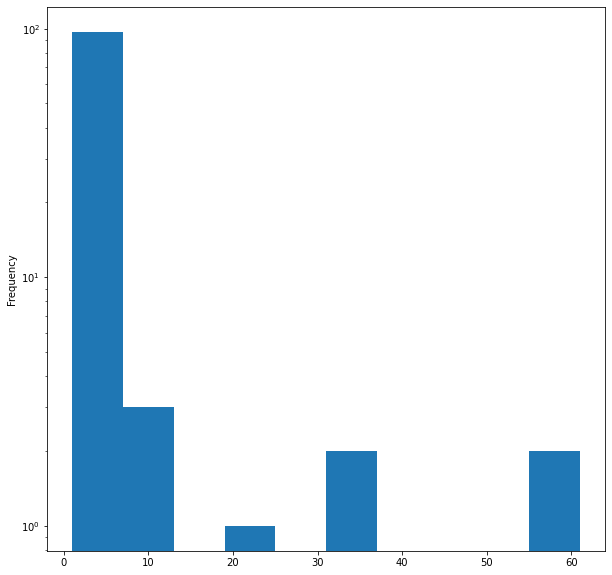

In [99]:
nx.degree_centrality(G).items()

plt.figure(figsize = (10,10))
degrees = pd.Series(
    {
        k:v for k,v in nx.degree(G)
    }
)
degrees.plot.hist()
plt.yscale("log")

In [115]:
element = set(dataset['D365_Health_Element'].values)
country = set(dataset['Country'].values)
centrality = pd.DataFrame(nx.degree_centrality(G).items(), columns = ['items', 'centrality']).sort_values(by='centrality', ascending=False)
country_centrality = centrality[centrality['items'].isin(country)]
element_centrality = centrality[centrality['items'].isin(element)]

print(country_centrality)
print(element_centrality)


               items  centrality
9              Haiti    0.067308
23           Liberia    0.057692
16             Ghana    0.057692
34            Malawi    0.048077
5             Rwanda    0.048077
..               ...         ...
73          Kiribati    0.009615
74             India    0.009615
76       Saint Lucia    0.009615
77          Maldives    0.009615
104  Kyrgyz Republic    0.009615

[94 rows x 2 columns]
                                             items  centrality
15   Pandemic Influenza and Other Emerging Threats    0.586538
1                                         HIV/AIDS    0.576923
18                                         Malaria    0.326923
13                Family Planning and Reproduction    0.317308
24                     Other Public Health Threats    0.182692
17                       Maternal and Child Health    0.115385
36                                             RDC    0.067308
103                                            HIV    0.009615
96            

### Using igraph package

In [42]:
import igraph
from igraph import Graph
G = Graph.DataFrame(dataset[['Country', 'D365_Health_Element']], directed=False)

# computing the clustering
communities = G.community_infomap()
                    # G.community_multilevel()
                    # G.community_infomap()
                    # G.community_walktrap()

# summary of the clustering
print(communities.summary())
# ex: 'Clustering with y elements and n clusters'

# get the cluster of each node
clusters = {n: c for n,c in zip(G.vs["name"], communities.membership)}

##### Plot clusters
import random
# import cairocffi

visual_style = {
    "edge_width": 0.3,
    "vertex_size": 1.5,
    "palette": "heat"
#     "layout": "fruchterman_reingold"
}

clusters = G.community_multilevel( weights=None, return_levels=False)
member = clusters.membership
new_cmap = ['#'+''.join([random.choice('0123456789abcdef') for x in range(6)]) for z in range(len(clusters))]

vcolors = {v: new_cmap[i] for i, c in enumerate(clusters) for v in c}
G.vs["color"] = [vcolors[v] for v in G.vs.indices]

ecolors = {e.index: new_cmap[member[e.tuple[0]]] if member[e.tuple[0]]==member[e.tuple[1]] else "#e0e0e0" for e in G.es}
eweights = {e.index: (3*G.vcount()) if member[e.tuple[0]]==member[e.tuple[1]] else 0.1 for e in G.es}
G.es["weight"] = [eweights[e.index] for e in G.es]
G.es["color"] = [ecolors[e] for e in G.es.indices]

visual_style["layout"] = G.layout_fruchterman_reingold(weights=G.es["weight"])
# igraph.plot(G, **visual_style)

igraph.plot(G)

ImportError: cannot import name 'is_bigraphical' from 'igraph._igraph' (c:\Users\jinfe\Documents\GitHub\supply_chain\.conda\lib\site-packages\igraph\_igraph.cp39-win_amd64.pyd)